In [11]:
import os
import pickle
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # Progress bar library
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, precision_score, recall_score

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [12]:
# Function to load motion data from a pickle file
def load_pickle_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# Example path (modify as per your dataset structure)
motion_pickle_path = "C:/how to sign dataset/language_pkls_cropTrue_shapeTrue/_0fO5ETSwyg_0-5-rgb_front.pkl"

# Load the motion data
motion_data = load_pickle_data(motion_pickle_path)

# Inspect the loaded motion data
print("Motion data keys:", motion_data.keys())  # Check what keys are available in the pickle file

# Paths to the CSV files
train_csv_path = "C:/how to sign dataset/language_pkls_cropTrue_shapeTrue/text_labels/how2sign_train.csv"
test_csv_path = "C:/how to sign dataset/language_pkls_cropTrue_shapeTrue/text_labels/how2sign_test.csv"
validation_csv_path = "C:/how to sign dataset/language_pkls_cropTrue_shapeTrue/text_labels/how2sign_val.csv"

# Load the CSV files
train_df = pd.read_csv(train_csv_path, sep='\t')
test_df = pd.read_csv(test_csv_path, sep='\t')
validation_df = pd.read_csv(validation_csv_path, sep='\t')

# Inspect the data
print("Train Data Sample: \n", train_df.head())
print("Test Data Sample: \n", test_df.head())
print("Validation Data Sample: \n", validation_df.head())


Motion data keys: dict_keys(['left_valid', 'right_valid', 'total_valid_index', '2d', 'smplx', 'unsmooth_smplx', 'bb2img_trans', 'focal', 'princpt', 'height', 'width'])
Train Data Sample: 
       VIDEO_ID               VIDEO_NAME     SENTENCE_ID  \
0  --7E2sU6zP4  --7E2sU6zP4-5-rgb_front  --7E2sU6zP4_10   
1  --7E2sU6zP4  --7E2sU6zP4-5-rgb_front  --7E2sU6zP4_11   
2  --7E2sU6zP4  --7E2sU6zP4-5-rgb_front  --7E2sU6zP4_12   
3  --7E2sU6zP4  --7E2sU6zP4-5-rgb_front  --7E2sU6zP4_13   
4  --7E2sU6zP4  --7E2sU6zP4-5-rgb_front   --7E2sU6zP4_5   

                SENTENCE_NAME   START     END  \
0  --7E2sU6zP4_10-5-rgb_front   94.95  106.38   
1  --7E2sU6zP4_11-5-rgb_front  107.50  125.18   
2  --7E2sU6zP4_12-5-rgb_front  125.18  136.09   
3  --7E2sU6zP4_13-5-rgb_front  136.52  141.03   
4   --7E2sU6zP4_5-5-rgb_front   42.68   49.33   

                                            SENTENCE  
0  And I call them decorative elements because ba...  
1  So they don't really have much of a symbolic m..

In [13]:
# Set a fixed maximum sequence length for padding
MAX_SEQ_LENGTH = 128  # Adjust this value based on your data


In [14]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Move the model to GPU if available
bert_model = bert_model.to(device)

# Function to generate embeddings for a list of sentences in batches
def generate_embeddings_in_batches(sentences, batch_size=16):
    all_embeddings = []
    all_attention_masks = []
    bert_model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for i in tqdm(range(0, len(sentences), batch_size), desc="Generating Embeddings"):
            batch_sentences = sentences[i:i+batch_size]
            encoded_inputs = tokenizer(
                list(batch_sentences),
                return_tensors='pt',
                padding='max_length',
                truncation=True,
                max_length=MAX_SEQ_LENGTH,
                return_attention_mask=True
            )
            input_ids = encoded_inputs['input_ids'].to(device)
            attention_mask = encoded_inputs['attention_mask'].to(device)

            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, MAX_SEQ_LENGTH, hidden_size)

            all_embeddings.append(last_hidden_state.cpu())
            all_attention_masks.append(attention_mask.cpu())

    # Concatenate all batches
    embeddings = torch.cat(all_embeddings, dim=0)  # Shape: (num_sentences, MAX_SEQ_LENGTH, hidden_size)
    attention_masks = torch.cat(all_attention_masks, dim=0)  # Shape: (num_sentences, MAX_SEQ_LENGTH)

    return embeddings, attention_masks

# Generate embeddings and attention masks for the train, test, and validation sets
train_embeddings, train_attention_masks = generate_embeddings_in_batches(train_df['SENTENCE'], batch_size=16)
test_embeddings, test_attention_masks = generate_embeddings_in_batches(test_df['SENTENCE'], batch_size=16)
validation_embeddings, validation_attention_masks = generate_embeddings_in_batches(validation_df['SENTENCE'], batch_size=16)

print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")
print(f"Validation embeddings shape: {validation_embeddings.shape}")


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Generating Embeddings: 100%|██████████| 109/109 [00:07<00:00, 15.51it/s]

Train embeddings shape: torch.Size([31165, 128, 768])
Test embeddings shape: torch.Size([2357, 128, 768])
Validation embeddings shape: torch.Size([1741, 128, 768])


In [15]:
# Function to extract necessary motion parameters from the smplx data
def extract_motion_data(motion_data):
    # Extract parameters from smplx
    smplx_data = motion_data['smplx']
    root_pose = smplx_data[:, :3]  # Root pose
    body_pose = smplx_data[:, 3:66]  # Body pose
    left_hand_pose = smplx_data[:, 66:111]  # Left hand pose
    right_hand_pose = smplx_data[:, 111:156]  # Right hand pose
    return root_pose, body_pose, left_hand_pose, right_hand_pose

# Function to pad or truncate motion sequences
def pad_or_truncate_motion_sequence(motion_sequence, target_length):
    seq_len = motion_sequence.shape[0]
    if seq_len > target_length:
        return motion_sequence[:target_length]
    elif seq_len < target_length:
        padding = np.zeros((target_length - seq_len, motion_sequence.shape[1]))
        return np.concatenate([motion_sequence, padding], axis=0)
    else:
        return motion_sequence

# Function to align text with motion data based on start and end times
def align_text_with_motion(df, embeddings, attention_masks):
    aligned_data = []
    root_pose, body_pose, left_hand_pose, right_hand_pose = extract_motion_data(motion_data)

    for idx in tqdm(range(len(df)), desc="Aligning Data"):
        row = df.iloc[idx]
        video_id = row['VIDEO_ID']
        start_frame = int(row['START'])
        end_frame = int(row['END'])

        # Extract motion segment based on frame indices
        motion_segment_root = root_pose[start_frame:end_frame]
        motion_segment_body = body_pose[start_frame:end_frame]
        motion_segment_left_hand = left_hand_pose[start_frame:end_frame]
        motion_segment_right_hand = right_hand_pose[start_frame:end_frame]

        # Pad or truncate motion sequences to MAX_SEQ_LENGTH
        motion_segment_root = pad_or_truncate_motion_sequence(motion_segment_root, MAX_SEQ_LENGTH)
        motion_segment_body = pad_or_truncate_motion_sequence(motion_segment_body, MAX_SEQ_LENGTH)
        motion_segment_left_hand = pad_or_truncate_motion_sequence(motion_segment_left_hand, MAX_SEQ_LENGTH)
        motion_segment_right_hand = pad_or_truncate_motion_sequence(motion_segment_right_hand, MAX_SEQ_LENGTH)

        motion_data_dict = {
            'root_pose': torch.tensor(motion_segment_root, dtype=torch.float32),
            'body_pose': torch.tensor(motion_segment_body, dtype=torch.float32),
            'left_hand_pose': torch.tensor(motion_segment_left_hand, dtype=torch.float32),
            'right_hand_pose': torch.tensor(motion_segment_right_hand, dtype=torch.float32)
        }

        aligned_data.append(motion_data_dict)

    return aligned_data


In [16]:
# Create datasets
train_motion_data_list = align_text_with_motion(train_df, train_embeddings, train_attention_masks)
test_motion_data_list = align_text_with_motion(test_df, test_embeddings, test_attention_masks)
validation_motion_data_list = align_text_with_motion(validation_df, validation_embeddings, validation_attention_masks)

class TextMotionDataset(Dataset):
    def __init__(self, embeddings, attention_masks, motion_data_list):
        self.embeddings = embeddings
        self.attention_masks = attention_masks
        self.motion_data_list = motion_data_list

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return {
            'text_embeddings': self.embeddings[idx],          # Shape: (MAX_SEQ_LENGTH, hidden_size)
            'attention_mask': self.attention_masks[idx],      # Shape: (MAX_SEQ_LENGTH)
            'motion_data': self.motion_data_list[idx]         # Dictionary with motion parameters
        }

# Create dataset instances
train_dataset = TextMotionDataset(train_embeddings, train_attention_masks, train_motion_data_list)
test_dataset = TextMotionDataset(test_embeddings, test_attention_masks, test_motion_data_list)
validation_dataset = TextMotionDataset(validation_embeddings, validation_attention_masks, validation_motion_data_list)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)


Aligning Data: 100%|██████████| 1741/1741 [00:00<00:00, 9567.74it/s]


In [19]:
class TextToMotionTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, num_layers=4, num_heads=8):
        super(TextToMotionTransformer, self).__init__()
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Linear layers for predicting separate motion parameters
        self.fc_root = nn.Linear(input_dim, 3)          # Root pose (3)
        self.fc_body = nn.Linear(input_dim, 63)         # Body pose (63)
        self.fc_left_hand = nn.Linear(input_dim, 45)    # Left hand pose (45)
        self.fc_right_hand = nn.Linear(input_dim, 45)   # Right hand pose (45)

    def forward(self, token_embeddings, attention_mask):
        # token_embeddings: (batch_size, seq_length, input_dim)
        # attention_mask: (batch_size, seq_length)

        # Permute token_embeddings to match Transformer input requirements
        token_embeddings = token_embeddings.permute(1, 0, 2)  # (seq_length, batch_size, input_dim)

        # Convert attention mask to key_padding_mask (True for padding tokens)
        key_padding_mask = attention_mask == 0  # Shape: (batch_size, seq_length)

        # Pass through Transformer Encoder
        transformer_output = self.transformer_encoder(
            token_embeddings,
            src_key_padding_mask=key_padding_mask  # (batch_size, seq_length)
        )  # (seq_length, batch_size, input_dim)

        # Transpose back to (batch_size, seq_length, input_dim)
        transformer_output = transformer_output.permute(1, 0, 2)

        # Predict motion parameters
        root_pose = self.fc_root(transformer_output)           # (batch_size, seq_length, 3)
        body_pose = self.fc_body(transformer_output)           # (batch_size, seq_length, 63)
        left_hand_pose = self.fc_left_hand(transformer_output) # (batch_size, seq_length, 45)
        right_hand_pose = self.fc_right_hand(transformer_output) # (batch_size, seq_length, 45)

        return root_pose, body_pose, left_hand_pose, right_hand_pose


In [20]:
# Initialize the model, loss function, and optimizer
model = TextToMotionTransformer(input_dim=768).to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Evaluation function to calculate various metrics
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    total_samples = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch_data in tqdm(data_loader, desc="Evaluating", leave=False):
            # Move data to device
            text_embeddings = batch_data['text_embeddings'].to(device)    # (batch_size, seq_length, input_dim)
            attention_mask = batch_data['attention_mask'].to(device)      # (batch_size, seq_length)
            motion_data = batch_data['motion_data']

            motion_data_root = motion_data['root_pose'].to(device)            # (batch_size, seq_length, 3)
            motion_data_body = motion_data['body_pose'].to(device)            # (batch_size, seq_length, 63)
            motion_data_left_hand = motion_data['left_hand_pose'].to(device)  # (batch_size, seq_length, 45)
            motion_data_right_hand = motion_data['right_hand_pose'].to(device)# (batch_size, seq_length, 45)

            # Forward pass
            root_pose_pred, body_pose_pred, left_hand_pred, right_hand_pred = model(text_embeddings, attention_mask)

            # Compute loss
            loss_root = criterion(root_pose_pred, motion_data_root)
            loss_body = criterion(body_pose_pred, motion_data_body)
            loss_left_hand = criterion(left_hand_pred, motion_data_left_hand)
            loss_right_hand = criterion(right_hand_pred, motion_data_right_hand)

            # Total loss
            total_loss += (loss_root + loss_body + loss_left_hand + loss_right_hand).item()
            total_samples += 1

            # Collect predictions and targets for evaluation metrics
            preds = torch.cat([root_pose_pred, body_pose_pred, left_hand_pred, right_hand_pred], dim=-1).cpu().numpy()
            targets = torch.cat([motion_data_root, motion_data_body, motion_data_left_hand, motion_data_right_hand], dim=-1).cpu().numpy()

            all_preds.append(preds)
            all_targets.append(targets)

    # Concatenate all predictions and targets
    all_preds = np.concatenate(all_preds, axis=0)     # (num_samples, seq_length, total_pose_dim)
    all_targets = np.concatenate(all_targets, axis=0) # (num_samples, seq_length, total_pose_dim)

    # Flatten sequences for metric calculation
    all_preds_flat = all_preds.reshape(-1, all_preds.shape[-1])
    all_targets_flat = all_targets.reshape(-1, all_targets.shape[-1])

    # Calculate evaluation metrics
    mse = mean_squared_error(all_targets_flat, all_preds_flat)
    mae = mean_absolute_error(all_targets_flat, all_preds_flat)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets_flat, all_preds_flat)

    metrics = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R2 Score': r2
    }

    return metrics, total_loss / total_samples

# Training loop with progress bar
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for batch_idx, batch_data in enumerate(train_loader):
        # Move data to device
        text_embeddings = batch_data['text_embeddings'].to(device)    # (batch_size, seq_length, input_dim)
        attention_mask = batch_data['attention_mask'].to(device)      # (batch_size, seq_length)
        motion_data = batch_data['motion_data']

        motion_data_root = motion_data['root_pose'].to(device)            # (batch_size, seq_length, 3)
        motion_data_body = motion_data['body_pose'].to(device)            # (batch_size, seq_length, 63)
        motion_data_left_hand = motion_data['left_hand_pose'].to(device)  # (batch_size, seq_length, 45)
        motion_data_right_hand = motion_data['right_hand_pose'].to(device)# (batch_size, seq_length, 45)

        # Forward pass
        root_pose_pred, body_pose_pred, left_hand_pred, right_hand_pred = model(text_embeddings, attention_mask)

        # Compute loss
        loss_root = criterion(root_pose_pred, motion_data_root)
        loss_body = criterion(body_pose_pred, motion_data_body)
        loss_left_hand = criterion(left_hand_pred, motion_data_left_hand)
        loss_right_hand = criterion(right_hand_pred, motion_data_right_hand)

        # Total loss
        total_loss = loss_root + loss_body + loss_left_hand + loss_right_hand

        # Backpropagation and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item()
        pbar.set_postfix({'Loss': total_loss.item()})
        pbar.update(1)

    pbar.close()

    # Evaluate on training set
    train_metrics, avg_train_loss = evaluate(model, train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Training Loss: {avg_train_loss:.4f}, Training Metrics: {train_metrics}")

    # Evaluate on validation set
    val_metrics, avg_val_loss = evaluate(model, validation_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Loss: {avg_val_loss:.4f}, Validation Metrics: {val_metrics}")

# Final Evaluation on Test Set
test_metrics, avg_test_loss = evaluate(model, test_loader)
print(f"Test Loss: {avg_test_loss:.4f}, Test Metrics: {test_metrics}")

# Save the model and embeddings
torch.save(model.state_dict(), "text_to_motion_transformer.pth")
torch.save({
    'train_embeddings': train_embeddings,
    'train_attention_masks': train_attention_masks,
    'test_embeddings': test_embeddings,
    'test_attention_masks': test_attention_masks,
    'validation_embeddings': validation_embeddings,
    'validation_attention_masks': validation_attention_masks
}, 'embeddings_and_masks.pth')


Epoch 1/15: 100%|██████████| 1948/1948 [02:06<00:00, 15.39it/s, Loss=0.114]


Epoch [1/15] Training Loss: 0.1249, Training Metrics: {'MSE': np.float32(0.006218533), 'MAE': np.float32(0.018256208), 'RMSE': np.float32(0.078857675), 'R2 Score': -7.582802772521973}


Epoch [1/15] Validation Loss: 0.1300, Validation Metrics: {'MSE': np.float32(0.006615596), 'MAE': np.float32(0.018728677), 'RMSE': np.float32(0.08133631), 'R2 Score': -7.256680965423584}


Epoch 2/15: 100%|██████████| 1948/1948 [02:05<00:00, 15.47it/s, Loss=0.117] 


Epoch [2/15] Training Loss: 0.1296, Training Metrics: {'MSE': np.float32(0.0066277995), 'MAE': np.float32(0.012327328), 'RMSE': np.float32(0.081411295), 'R2 Score': -11.200409889221191}


Epoch [2/15] Validation Loss: 0.1352, Validation Metrics: {'MSE': np.float32(0.006893029), 'MAE': np.float32(0.012665555), 'RMSE': np.float32(0.08302427), 'R2 Score': -10.604116439819336}


Epoch 3/15: 100%|██████████| 1948/1948 [02:04<00:00, 15.61it/s, Loss=0.0847]


Epoch [3/15] Training Loss: 0.1315, Training Metrics: {'MSE': np.float32(0.006694063), 'MAE': np.float32(0.012864864), 'RMSE': np.float32(0.081817254), 'R2 Score': -0.7768277525901794}


Epoch [3/15] Validation Loss: 0.1371, Validation Metrics: {'MSE': np.float32(0.0069726063), 'MAE': np.float32(0.013148791), 'RMSE': np.float32(0.083502136), 'R2 Score': -0.7614617943763733}


Epoch 4/15: 100%|██████████| 1948/1948 [02:03<00:00, 15.74it/s, Loss=0.2]   


Epoch [4/15] Training Loss: 0.1344, Training Metrics: {'MSE': np.float32(0.0067536905), 'MAE': np.float32(0.01260716), 'RMSE': np.float32(0.08218084), 'R2 Score': -0.8218551278114319}


Epoch [4/15] Validation Loss: 0.1401, Validation Metrics: {'MSE': np.float32(0.0070451614), 'MAE': np.float32(0.012996897), 'RMSE': np.float32(0.08393546), 'R2 Score': -0.8013370037078857}


Epoch 5/15: 100%|██████████| 1948/1948 [02:04<00:00, 15.70it/s, Loss=0.0894]


Epoch [5/15] Training Loss: 0.1271, Training Metrics: {'MSE': np.float32(0.0066777254), 'MAE': np.float32(0.01564595), 'RMSE': np.float32(0.08171735), 'R2 Score': -11.220856666564941}


Epoch [5/15] Validation Loss: 0.1325, Validation Metrics: {'MSE': np.float32(0.006999413), 'MAE': np.float32(0.01606034), 'RMSE': np.float32(0.083662495), 'R2 Score': -10.797680854797363}


Epoch 6/15: 100%|██████████| 1948/1948 [02:05<00:00, 15.54it/s, Loss=0.073] 


Epoch [6/15] Training Loss: 0.1275, Training Metrics: {'MSE': np.float32(0.0064563095), 'MAE': np.float32(0.01131534), 'RMSE': np.float32(0.08035117), 'R2 Score': -0.2648164927959442}


Epoch [6/15] Validation Loss: 0.1329, Validation Metrics: {'MSE': np.float32(0.0067146993), 'MAE': np.float32(0.011598934), 'RMSE': np.float32(0.081943266), 'R2 Score': -0.24459262192249298}


Epoch 7/15: 100%|██████████| 1948/1948 [02:04<00:00, 15.64it/s, Loss=0.0726]


Epoch [7/15] Training Loss: 0.1269, Training Metrics: {'MSE': np.float32(0.00643805), 'MAE': np.float32(0.011799504), 'RMSE': np.float32(0.08023746), 'R2 Score': -1.6872472763061523}


Epoch [7/15] Validation Loss: 0.1323, Validation Metrics: {'MSE': np.float32(0.0066991057), 'MAE': np.float32(0.0120835975), 'RMSE': np.float32(0.08184806), 'R2 Score': -1.6867820024490356}


Epoch 8/15: 100%|██████████| 1948/1948 [02:04<00:00, 15.66it/s, Loss=0.128] 


Epoch [8/15] Training Loss: 0.1279, Training Metrics: {'MSE': np.float32(0.006564784), 'MAE': np.float32(0.011245062), 'RMSE': np.float32(0.08102335), 'R2 Score': -2.7625105381011963}


Epoch [8/15] Validation Loss: 0.1334, Validation Metrics: {'MSE': np.float32(0.0068253265), 'MAE': np.float32(0.011608797), 'RMSE': np.float32(0.08261553), 'R2 Score': -2.6980559825897217}


Epoch 9/15: 100%|██████████| 1948/1948 [02:04<00:00, 15.66it/s, Loss=0.128] 


Epoch [9/15] Training Loss: 0.1280, Training Metrics: {'MSE': np.float32(0.0065224017), 'MAE': np.float32(0.0113624595), 'RMSE': np.float32(0.08076139), 'R2 Score': -0.11074535548686981}


Epoch [9/15] Validation Loss: 0.1335, Validation Metrics: {'MSE': np.float32(0.0067831087), 'MAE': np.float32(0.01170039), 'RMSE': np.float32(0.08235963), 'R2 Score': -0.09917089343070984}


Epoch 10/15: 100%|██████████| 1948/1948 [02:04<00:00, 15.70it/s, Loss=0.146] 


Epoch [10/15] Training Loss: 0.1263, Training Metrics: {'MSE': np.float32(0.006376132), 'MAE': np.float32(0.012022845), 'RMSE': np.float32(0.07985069), 'R2 Score': -0.18783988058567047}


Epoch [10/15] Validation Loss: 0.1317, Validation Metrics: {'MSE': np.float32(0.006668713), 'MAE': np.float32(0.0123437345), 'RMSE': np.float32(0.081662185), 'R2 Score': -0.16389137506484985}


Epoch 11/15: 100%|██████████| 1948/1948 [02:03<00:00, 15.81it/s, Loss=0.114] 


Epoch [11/15] Training Loss: 0.1274, Training Metrics: {'MSE': np.float32(0.006489478), 'MAE': np.float32(0.010919553), 'RMSE': np.float32(0.080557294), 'R2 Score': -0.24306876957416534}


Epoch [11/15] Validation Loss: 0.1328, Validation Metrics: {'MSE': np.float32(0.006748226), 'MAE': np.float32(0.0113468915), 'RMSE': np.float32(0.08214758), 'R2 Score': -0.23351550102233887}


Epoch 12/15: 100%|██████████| 1948/1948 [02:03<00:00, 15.78it/s, Loss=0.137] 


Epoch [12/15] Training Loss: 0.1264, Training Metrics: {'MSE': np.float32(0.006382434), 'MAE': np.float32(0.012336468), 'RMSE': np.float32(0.07989014), 'R2 Score': -0.31727755069732666}


Epoch [12/15] Validation Loss: 0.1318, Validation Metrics: {'MSE': np.float32(0.0066747344), 'MAE': np.float32(0.01263413), 'RMSE': np.float32(0.08169905), 'R2 Score': -0.30029168725013733}


Epoch 13/15: 100%|██████████| 1948/1948 [02:04<00:00, 15.70it/s, Loss=0.115] 


Epoch [13/15] Training Loss: 0.1277, Training Metrics: {'MSE': np.float32(0.0065565), 'MAE': np.float32(0.011131434), 'RMSE': np.float32(0.08097222), 'R2 Score': -0.8932381868362427}


Epoch [13/15] Validation Loss: 0.1332, Validation Metrics: {'MSE': np.float32(0.0068155243), 'MAE': np.float32(0.01151398), 'RMSE': np.float32(0.08255619), 'R2 Score': -0.8969926238059998}


Epoch 14/15: 100%|██████████| 1948/1948 [02:03<00:00, 15.73it/s, Loss=0.166] 


Epoch [14/15] Training Loss: 0.1315, Training Metrics: {'MSE': np.float32(0.006715854), 'MAE': np.float32(0.0119785955), 'RMSE': np.float32(0.081950314), 'R2 Score': -0.8862830996513367}


Epoch [14/15] Validation Loss: 0.1372, Validation Metrics: {'MSE': np.float32(0.0069964873), 'MAE': np.float32(0.0123031065), 'RMSE': np.float32(0.08364501), 'R2 Score': -0.8247396945953369}


Epoch 15/15: 100%|██████████| 1948/1948 [02:05<00:00, 15.58it/s, Loss=0.113] 


Epoch [15/15] Training Loss: 0.1270, Training Metrics: {'MSE': np.float32(0.006440042), 'MAE': np.float32(0.011275066), 'RMSE': np.float32(0.080249876), 'R2 Score': -2.0347766876220703}


Epoch [15/15] Validation Loss: 0.1324, Validation Metrics: {'MSE': np.float32(0.006699767), 'MAE': np.float32(0.011547479), 'RMSE': np.float32(0.0818521), 'R2 Score': -2.0800883769989014}


Test Loss: 0.1314, Test Metrics: {'MSE': np.float32(0.00665146), 'MAE': np.float32(0.011481967), 'RMSE': np.float32(0.081556484), 'R2 Score': -1.9822744131088257}


In [23]:
import torch
import gc

# Free up memory by clearing any existing cached data
torch.cuda.empty_cache()
gc.collect()

# Function to load the trained model and embeddings on CPU
def load_model_and_embeddings_cpu(model_path, embedding_path):
    # Load the model onto the CPU to avoid memory overflow on GPU
    model = TextToMotionTransformer(input_dim=768)  # Ensure input_dim matches the one used during training
    model.load_state_dict(torch.load(model_path, map_location='cpu'))  # Load model onto CPU
    model.to(device)  # Move model to GPU if available
    model.eval()

    # Load embeddings and attention masks onto CPU
    saved_data = torch.load(embedding_path, map_location='cpu')
    train_embeddings = saved_data['train_embeddings']
    train_attention_masks = saved_data['train_attention_masks']
    test_embeddings = saved_data['test_embeddings']
    test_attention_masks = saved_data['test_attention_masks']
    validation_embeddings = saved_data['validation_embeddings']
    validation_attention_masks = saved_data['validation_attention_masks']

    return model, train_embeddings, train_attention_masks, test_embeddings, test_attention_masks, validation_embeddings, validation_attention_masks

# Load model and embeddings on CPU and move the model to GPU afterward
model, train_embeddings, train_attention_masks, test_embeddings, test_attention_masks, validation_embeddings, validation_attention_masks = load_model_and_embeddings_cpu(model_path, embedding_path)
print("Model and embeddings loaded successfully!")

# Free up any additional memory after loading
torch.cuda.empty_cache()
gc.collect()


C:\Users\Admin\AppData\Local\Temp\ipykernel_16336\3277169616.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location='

Model and embeddings loaded successfully!


19

In [24]:
# Move the model and inputs to CPU for evaluation
device = torch.device('cpu')
model.to(device)


TextToMotionTransformer(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc_root): Linear(in_features=768, out_features=3, bias=True)
  (fc_body): Linear(in_features=768, out_features=63, bias=True)
  (fc_left_hand): Linear(in_features=768, out_features=45, bias=True)
  (fc_right_hand): Linear(in_features=768, out_features=4

In [25]:
# Load the BERT tokenizer and model (same as used during training)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.to(device)
bert_model.eval()

# Function to generate BERT embeddings for a given text input
def generate_bert_embeddings(text):
    # Tokenize and generate token embeddings
    inputs = tokenizer(
        text,
        return_tensors='pt',
        padding='max_length',
        truncation=True,
        max_length=128,  # Ensure this matches the MAX_SEQ_LENGTH used during training
        return_attention_mask=True
    )
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = bert_model(**inputs)

    # Get the token embeddings (last hidden state)
    token_embeddings = outputs.last_hidden_state.squeeze(0)  # Remove batch dimension
    attention_mask = inputs['attention_mask'].squeeze(0)     # Remove batch dimension

    return token_embeddings, attention_mask


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [30]:
# Example text input
text_input = "And just let those fingers relax"

# Generate BERT embeddings for the input text
text_embeddings, attention_mask = generate_bert_embeddings(text_input)

# Reshape embeddings and attention mask to match the expected input format
text_embeddings = text_embeddings.unsqueeze(0)  # Shape: (1, seq_length, hidden_size)
attention_mask = attention_mask.unsqueeze(0)    # Shape: (1, seq_length)

# Move to the device
text_embeddings = text_embeddings.to(device)
attention_mask = attention_mask.to(device)

# Pass through the model to generate motion parameters
with torch.no_grad():
    root_pose_pred, body_pose_pred, left_hand_pred, right_hand_pred = model(text_embeddings, attention_mask)

# Print the predicted motion parameters
print("Root Pose Prediction:\n", root_pose_pred.cpu().numpy())
print("Body Pose Prediction:\n", body_pose_pred.cpu().numpy())
print("Left Hand Pose Prediction:\n", left_hand_pred.cpu().numpy())
print("Right Hand Pose Prediction:\n", right_hand_pred.cpu().numpy())


Root Pose Prediction:
 [[[0.03734382 0.00041058 0.00052578]
  [0.03734384 0.00041058 0.00052578]
  [0.03734382 0.00041058 0.00052578]
  [0.03734381 0.00041058 0.00052578]
  [0.03734381 0.00041058 0.00052578]
  [0.03734382 0.00041058 0.00052578]
  [0.03734384 0.00041058 0.00052578]
  [0.03734383 0.00041058 0.00052578]
  [0.03734384 0.00041058 0.00052578]
  [0.03734383 0.00041058 0.00052578]
  [0.03734383 0.00041058 0.00052578]
  [0.03734383 0.00041058 0.00052578]
  [0.03734382 0.00041058 0.00052578]
  [0.03734383 0.00041058 0.00052578]
  [0.03734384 0.00041058 0.00052578]
  [0.03734382 0.00041058 0.00052578]
  [0.03734384 0.00041058 0.00052578]
  [0.03734383 0.00041058 0.00052578]
  [0.03734383 0.00041058 0.00052578]
  [0.03734381 0.00041058 0.00052578]
  [0.03734381 0.00041058 0.00052578]
  [0.03734383 0.00041058 0.00052578]
  [0.03734384 0.00041058 0.00052578]
  [0.03734383 0.00041058 0.00052578]
  [0.03734382 0.00041058 0.00052578]
  [0.03734383 0.00041058 0.00052578]
  [0.03734383 0

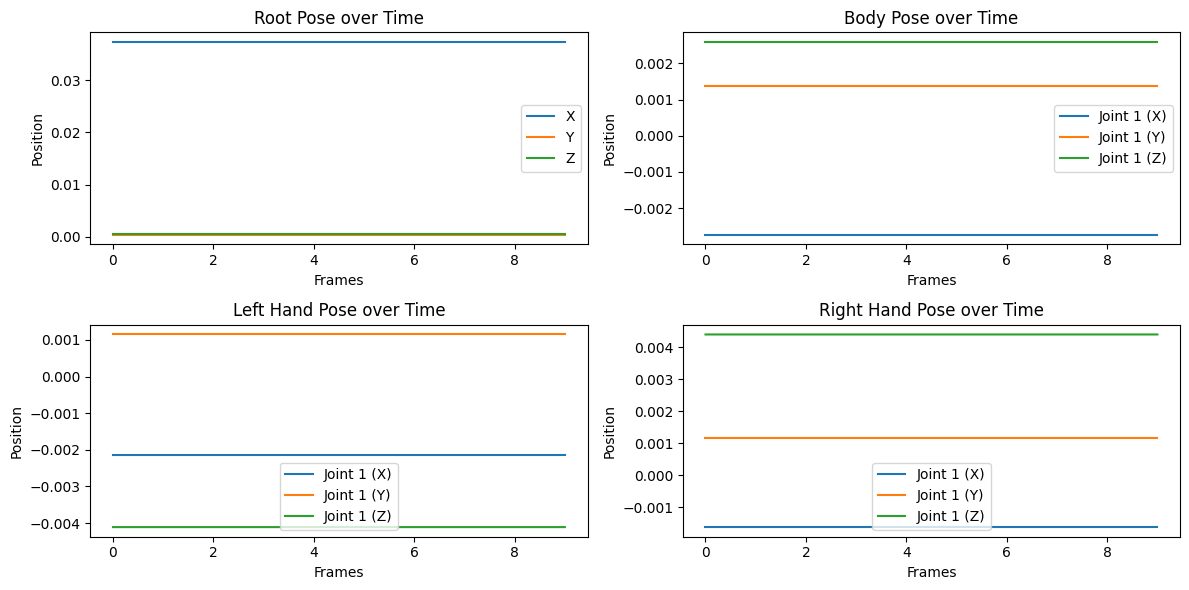

In [31]:
import matplotlib.pyplot as plt

def visualize_pose_over_time(root_pose, body_pose, left_hand_pose, right_hand_pose, num_frames=10):
    """
    Visualizes the predicted root, body, and hand poses over time using line plots.
    Args:
    - root_pose (numpy array): Root pose predictions (seq_length, 3).
    - body_pose (numpy array): Body pose predictions (seq_length, 63).
    - left_hand_pose (numpy array): Left hand pose predictions (seq_length, 45).
    - right_hand_pose (numpy array): Right hand pose predictions (seq_length, 45).
    - num_frames (int): Number of frames to visualize. Default is 10.
    """
    # Convert tensors to numpy arrays if needed
    if isinstance(root_pose, torch.Tensor):
        root_pose = root_pose.cpu().numpy()
    if isinstance(body_pose, torch.Tensor):
        body_pose = body_pose.cpu().numpy()
    if isinstance(left_hand_pose, torch.Tensor):
        left_hand_pose = left_hand_pose.cpu().numpy()
    if isinstance(right_hand_pose, torch.Tensor):
        right_hand_pose = right_hand_pose.cpu().numpy()

    # Select a subset of frames for visualization
    root_pose = root_pose[:num_frames]
    body_pose = body_pose[:num_frames]
    left_hand_pose = left_hand_pose[:num_frames]
    right_hand_pose = right_hand_pose[:num_frames]

    # Plot Root Pose over Time
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.plot(root_pose[:, 0], label='X')
    plt.plot(root_pose[:, 1], label='Y')
    plt.plot(root_pose[:, 2], label='Z')
    plt.title('Root Pose over Time')
    plt.xlabel('Frames')
    plt.ylabel('Position')
    plt.legend()

    # Plot Body Pose over Time (for a selected joint)
    plt.subplot(2, 2, 2)
    plt.plot(body_pose[:, 0], label='Joint 1 (X)')
    plt.plot(body_pose[:, 1], label='Joint 1 (Y)')
    plt.plot(body_pose[:, 2], label='Joint 1 (Z)')
    plt.title('Body Pose over Time')
    plt.xlabel('Frames')
    plt.ylabel('Position')
    plt.legend()

    # Plot Left Hand Pose over Time (for a selected joint)
    plt.subplot(2, 2, 3)
    plt.plot(left_hand_pose[:, 0], label='Joint 1 (X)')
    plt.plot(left_hand_pose[:, 1], label='Joint 1 (Y)')
    plt.plot(left_hand_pose[:, 2], label='Joint 1 (Z)')
    plt.title('Left Hand Pose over Time')
    plt.xlabel('Frames')
    plt.ylabel('Position')
    plt.legend()

    # Plot Right Hand Pose over Time (for a selected joint)
    plt.subplot(2, 2, 4)
    plt.plot(right_hand_pose[:, 0], label='Joint 1 (X)')
    plt.plot(right_hand_pose[:, 1], label='Joint 1 (Y)')
    plt.plot(right_hand_pose[:, 2], label='Joint 1 (Z)')
    plt.title('Right Hand Pose over Time')
    plt.xlabel('Frames')
    plt.ylabel('Position')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualize the predictions for the first 10 frames
visualize_pose_over_time(
    root_pose_pred.squeeze(0),
    body_pose_pred.squeeze(0),
    left_hand_pred.squeeze(0),
    right_hand_pred.squeeze(0),
    num_frames=10
)
